In [1155]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

class MultiModalAgentSimulator:
    def __init__(self, N, M, sigma_y, delta_mu, delta_sigma, delta_alpha, nu):
        self.N = N                  # Number of agents
        self.M = M                  # Number of modes 
        self.sigma_y = sigma_y      # Observation variance
        self.delta_mu = delta_mu    # Mixing rate for mean social update
        self.delta_sigma = delta_sigma  # Mixing rate for variance social update
        self.delta_alpha = delta_alpha    # Increment for weight social update
        self.nu = nu   # network variance bias
        
        # Network Configuration
        # Fully connected network
        # self.W = np.ones((N, N)) / (N-1)
        # np.fill_diagonal(self.W, 0) # No self-loop
        # self.D = np.diag(np.sum(self.W, axis=0))
        # BA network (remember to set m0)
        #self.G = nx.barabasi_albert_graph(N, 2)
        # ER network 
        #self.G = nx.erdos_renyi_graph(N,0.15)
        # WS network
        self.G = nx.watts_strogatz_graph(N, 3, 0.2, seed=77)
        self.Adj = nx.to_numpy_array(self.G)
        self.Adj[0,1:25] = 1
        self.Adj[1:25,0] = 1
        self.G = nx.from_numpy_array(self.Adj)
        np.random.seed(58)
        W_random = np.random.rand(N, N) * self.Adj 
        self.W = W_random / W_random.sum(axis=1, keepdims=True)
        # self.W[0,1:] = 2*self.W[0,1:]
        # self.W[0,1:] = 2*self.W[0,1:]
        np.nan_to_num(self.W, copy=False)
        self.D = np.diag(np.sum(self.W, axis=1))
        #check = (self.W - self.D)@n
        
    def initialize(self, mu_init, sigma_init, alpha_init):
        # Initialize mean, variance, and weight for each agent and each mode
        # mu_init: shape (N, M)
        # sigma_init: shape (N, M)
        # alpha_init: shape (N, M) (Each row must sum to 1)
        self.mu = np.array(mu_init)
        self.sigma = np.array(sigma_init)
        self.alpha = np.array(alpha_init)
        
    def bayesian_update_variance(self, y):
        # Variance update
        self.sigma_plus = self.sigma * self.sigma_y / (self.sigma + self.sigma_y)
        
    def social_update_variance(self):
        # Variance update (average, but with bias, f(0,...,0) = nu)
        sigma_new = np.zeros_like(self.sigma)
        for j in range(self.N):
            for i in range(self.M):
                neighbor_sigma = np.delete(self.sigma_plus[:, i], j)
                f_sigma = self.delta_sigma * np.mean(neighbor_sigma - self.sigma_plus[j, i]) + self.nu
                sigma_new[j, i] = self.sigma_plus[j, i] + f_sigma
        self.sigma = sigma_new

    def overall_update_mean(self, y, theta):
        sigma_star = (self.nu + np.sqrt(self.nu**2 + 4*self.nu*self.sigma_y)) / 2
        I = np.eye(self.N)
        ones = np.ones(self.N)
        Sigma = (self.sigma_y / (sigma_star + self.sigma_y)) * I
        A = Sigma @ (I + self.delta_mu*self.W - self.delta_mu*self.D)  
        B = I - Sigma
        stability_flag = self.is_stable(A)
        if stability_flag:
            for m in range(self.M):
                mu_old = self.mu[:, m].copy()
                mu_new = np.zeros_like(mu_old)
                mu_new = A @ mu_old + (B @ ones) * y  
                self.mu[:, m] = mu_new 
            mu_star = ones * theta
            return mu_star
        else:
            print('The mean dynamics do not converge.')
            return 
            
    def overall_update_mean_stubborn(self, y, mu_dagger, theta):
        sigma_star = (self.nu + np.sqrt(self.nu**2 + 4*self.nu*self.sigma_y)) / 2
        I = np.eye(self.N)
        ones = np.ones(self.N)
        Sigma = (self.sigma_y / (sigma_star + self.sigma_y)) * I
        A = Sigma @ (I + self.delta_mu*self.W - self.delta_mu*self.D)  
        B = I - Sigma
        # Submatrices
        A_minus1_1 = A[1:, 0]         
        A_minus1_minus1 = A[1:, 1:]    
        B_minus1_minus1 = B[1:, 1:]    
        stability_flag = self.is_stable(A_minus1_minus1)

        if stability_flag:
            for m in range(self.M):
                mu_old = self.mu[:, m].copy()
                mu_new = np.zeros_like(mu_old)
                mu_new[0] = mu_dagger  
                mu_new[1:] = A_minus1_1 * mu_dagger + A_minus1_minus1 @ mu_old[1:] + B_minus1_minus1 @ np.ones(self.N-1) * y
                self.mu[:, m] = mu_new
                
            mu_star = np.zeros_like(mu_old)
            mu_star[0] = mu_dagger  
            mu_star[1:] = np.linalg.inv(np.eye(self.N-1) - A_minus1_minus1) @ (A_minus1_1 * mu_dagger + B_minus1_minus1 @ np.ones(self.N-1) * theta)
            return mu_star
        else:
            print('The mean dynamics do not converge.')
            return 
        
    def simulate_variance(self, theta, max_steps):
        sigma_history = [self.sigma.copy()]
        sigma_star = (self.nu + np.sqrt(self.nu**2 + 4*self.nu*self.sigma_y)) / 2
        for _ in range(max_steps):
            # Generate observations
            y = theta + np.random.normal(0, np.sqrt(self.sigma_y))
            # Bayesian update
            self.bayesian_update_variance(y)
            # Social update
            self.social_update_variance()
            # Record
            sigma_history.append(self.sigma.copy())
            
        return np.array(sigma_history), sigma_star

    def simulate_mean(self, theta, max_steps):
        mu_history = [self.mu.copy()]
        for _ in range(max_steps):
            # Generate observations
            y = theta + np.random.normal(0, np.sqrt(self.sigma_y))
            # Update
            mu_star = self.overall_update_mean(y, theta)
            # Record
            mu_history.append(self.mu.copy())
            
        return np.array(mu_history), mu_star

    def simulate_mean_stubborn(self, theta, max_steps):
        mu_history = [self.mu.copy()]
        mu_dagger = -1
        for _ in range(max_steps):
            # Generate observations
            y = theta + np.random.normal(0, np.sqrt(self.sigma_y))
            # Update
            mu_star = self.overall_update_mean_stubborn(y, mu_dagger, theta)
            # Record
            mu_history.append(self.mu.copy())
            
        return np.array(mu_history), mu_star

    def is_stable(self, A):
        eigenvalues = np.linalg.eigvals(A)  
        spectral_radius = max(abs(eigenvalues))  
        return spectral_radius < 1  
    


In [1156]:
# Parameter Setting 
N = 50   # Number of agents
M = 2   # Number of modes
delta_mu = 0.6   # Mixing rate for mean social update
delta_sigma = 0.1   # Mixing rate for variance social update
delta_alpha = 0.1   # Increment for weight social update
theta_true = 1  # True media bias
sigma_y = 0.1   # Observation variance: 1 or 0.1
time_steps = 2000   # Time steps

# Initial mean, variance, and weight
mu_ub = 1
mu_lb = -1
mu_init = np.zeros((N, M))
for j in range(M):
    upper = mu_ub - (mu_ub - mu_lb) * j / M
    lower = mu_ub - (mu_ub - mu_lb) * (j + 1) / M
    mu_init[:, j] = np.random.uniform(lower, upper, N)
#sigma_init = np.random.uniform(0.3, 1.0, (N, M))  
sigma_init = np.ones((N,M))
nu = 0.1 # network variance bias
alpha_init = np.ones((N, M)) / M

sigma_star = (nu + np.sqrt(nu**2 + 4*nu*sigma_y)) / 2


# Simulation Execution 
stubborn = 0
if stubborn == 0:
    sim = MultiModalAgentSimulator(N, M, sigma_y, delta_mu, delta_sigma, delta_alpha, nu)
    sim.initialize(mu_init, sigma_init, alpha_init)
    [sigma_history, sigma_star] = sim.simulate_variance(theta=theta_true, max_steps = time_steps)
    [mu_history, mu_star] = sim.simulate_mean(theta=theta_true, max_steps = time_steps)
else:
    mu_init[0,:] = mu_lb
    sim = MultiModalAgentSimulator(N, M, sigma_y, delta_mu, delta_sigma, delta_alpha, nu)
    sim.initialize(mu_init, sigma_init, alpha_init)
    [sigma_history, sigma_star] = sim.simulate_variance(theta=theta_true, max_steps = time_steps)
    [mu_history, mu_star] = sim.simulate_mean_stubborn(theta=theta_true, max_steps = time_steps)


In [1157]:
plt.rcParams.update({
    "font.size": 14,            
    "font.family": "Times New Roman",     
    "axes.labelsize": 14,        
    "axes.titlesize": 14,        
    "xtick.labelsize": 12,       
    "ytick.labelsize": 12,       
    "legend.fontsize": 12,       
    "lines.linewidth": 2,       
    "lines.markersize": 6,      
    "savefig.dpi": 300,         
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsfonts}'
})


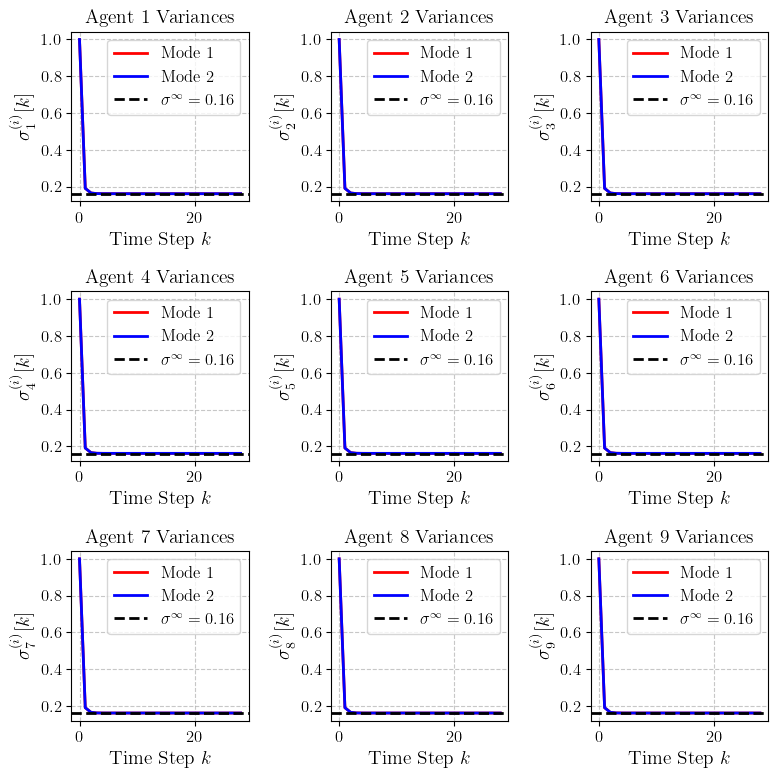

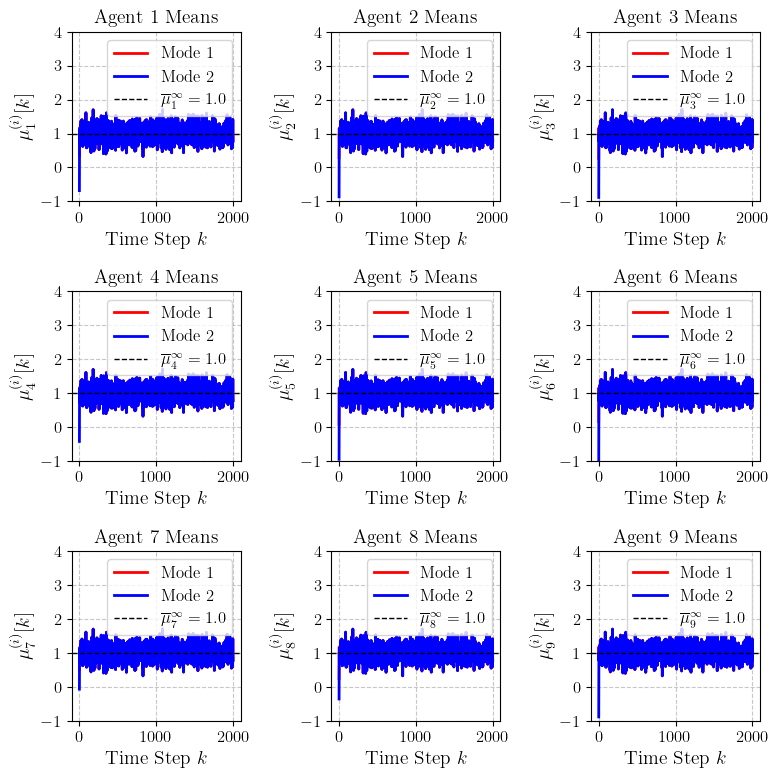

In [1158]:
# Sigma Results Visualization
ratio = np.round(sigma_y / sigma_star, 2)
sigma_star = np.round(sigma_star,2)
plt.figure(figsize=(8, 8))
modes = ['Mode 1', 'Mode 2']
colors = ['r','b'] 
cut_off = 29
Q = 9
for agent_id in range(Q):
    plt.subplot(3, 3, agent_id + 1)
    for mode in range(M):
        plt.plot(sigma_history[:cut_off, agent_id, mode], color=colors[mode], linestyle='-', 
                 label=modes[mode])  
    plt.axhline(y=sigma_star, color='k', linestyle='--', label=fr'$\sigma^\infty={sigma_star}$')
    plt.title(f'Agent {agent_id+1} Variances')
    plt.xlabel('Time Step $k$')
    plt.ylabel(f'$\\sigma^{{(i)}}_{{{agent_id+1}}}[k]$')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='upper right')  
plt.tight_layout()
if stubborn == 1:
    plt.savefig(f's_{ratio}_thm2.jpg',dpi = 300, bbox_inches='tight')
else:
    plt.savefig(f'ns_{ratio}_thm2.jpg',dpi = 300, bbox_inches='tight')
    
plt.show()
# Mean Results Visualization
plt.figure(figsize=(8, 8))
modes = ['Mode 1', 'Mode 2']
colors = ['r','b'] 

for agent_id in range(Q):
    plt.subplot(3, 3, agent_id + 1)
    for mode in range(M):
        plt.plot(mu_history[:, agent_id, mode], color=colors[mode], linestyle='-', 
                 label=modes[mode])  
    plt.axhline(y=mu_star[agent_id], color='k', linestyle='--', linewidth=1, label=fr'$\overline{{\mu}}^\infty_{{{agent_id+1}}}={np.round(mu_star[agent_id],2)}$')
    plt.title(f'Agent {agent_id+1} Means')
    plt.xlabel('Time Step $k$')
    plt.ylabel(f'$\\mu^{{(i)}}_{{{agent_id+1}}}[k]$')
    plt.ylim(-1,4)
    plt.yticks([-1,0,1,2,3,4])
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='upper right') 
plt.tight_layout()
if stubborn == 1:
    plt.savefig(f's_{ratio}_thm4.jpg',dpi = 300, bbox_inches='tight')
else:
    plt.savefig(f'ns_{ratio}_thm3.jpg',dpi = 300, bbox_inches='tight')
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(
/var/folders/j3/qxt55s6x7nl_dq8k1rvms0480000gn/T/ipykernel_1914/3328858487.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


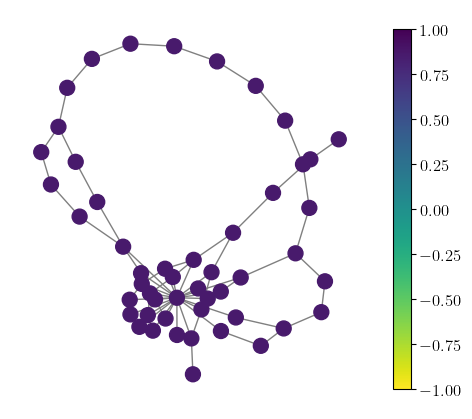

In [1159]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

norm = mcolors.Normalize(vmin=-1, vmax=1)
cmap = cm.viridis_r
u = np.mean(mu_history[time_steps-1-1000:time_steps-1, :, 0], axis=0)
node_colors = [cmap(norm(mu_history[time_steps-1, node, 0])) for node in sim.G.nodes()]

plt.figure(figsize=(4.5, 4))
pos = nx.spring_layout(sim.G)

nx.draw(sim.G, pos, with_labels=False, node_size=115, node_color=node_colors, cmap=cmap, edge_color="gray", font_size=12, font_weight="bold")

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca(), shrink=0.9)
#cbar.set_label(r'$\mathbb{E}\{{\mu^{(1)}_{j}}\}$', rotation=0, labelpad=25)
#cbar.set_label(r'$\mu^\infty_{j}$', rotation=0, labelpad=25)
plt.tight_layout()  
if stubborn == 1:
    plt.savefig(f's_{ratio}.jpg', dpi=300, bbox_inches='tight')
else:
    plt.savefig(f'ns_{ratio}.jpg', dpi=300, bbox_inches='tight')
    
plt.show()
